In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks'
!pwd

/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks
/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks


In [3]:
import sys
import os
import torch
import matplotlib.pyplot as plt
# Add project root to sys.path (one directory up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data_loader import ShanghaiTechDataModule
from src.train import train_model
from torchvision import transforms
from torchvision.models import get_model

### Resnet Density Map

Using device: cuda
Using CUDA: Tesla T4


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[resnet50] Epoch 1/10  Train MSE: 0.003837, MAE: 0.001798  Val   MSE: 0.001136, MAE: 0.001056


[resnet50] Epoch 2/10  Train MSE: 0.000889, MAE: 0.001049  Val   MSE: 0.000874, MAE: 0.001035


[resnet50] Epoch 3/10  Train MSE: 0.000778, MAE: 0.001022  Val   MSE: 0.000803, MAE: 0.000935


[resnet50] Epoch 4/10  Train MSE: 0.000685, MAE: 0.000939  Val   MSE: 0.000811, MAE: 0.000955


[resnet50] Epoch 5/10  Train MSE: 0.000486, MAE: 0.000821  Val   MSE: 0.000681, MAE: 0.000853


[resnet50] Epoch 6/10  Train MSE: 0.000518, MAE: 0.000843  Val   MSE: 0.000663, MAE: 0.000859


[resnet50] Epoch 7/10  Train MSE: 0.000419, MAE: 0.000794  Val   MSE: 0.000715, MAE: 0.000837


[resnet50] Epoch 8/10  Train MSE: 0.000364, MAE: 0.000746  Val   MSE: 0.000687, MAE: 0.000816


[resnet50] Epoch 9/10  Train MSE: 0.000377, MAE: 0.000745  Val   MSE: 0.000842, MAE: 0.000869


[resnet50] Epoch 10/10  Train MSE: 0.000393, MAE: 0.000754  Val   MSE: 0.000869, MAE: 0.000894
Saved weights to ../models/pth/part_A_resnet50.pth


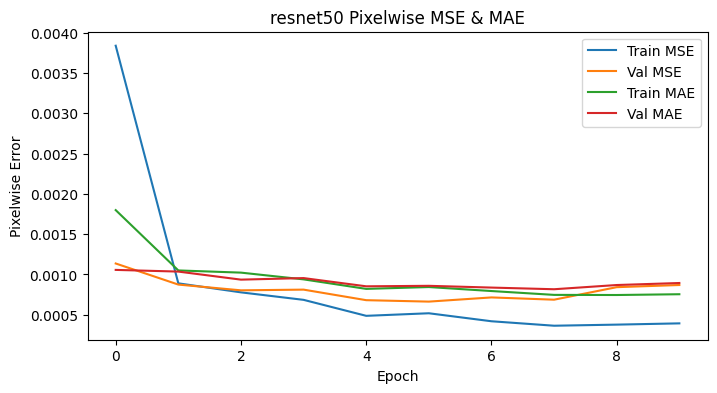

In [4]:
#Train

device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) Prepare the data
data_module = ShanghaiTechDataModule(
    data_folder="../data/ShanghaiTech",
    part="part_A",
    validation_split=0.1,
    sigma=5,
    return_count=False,
    batch_size=8,
    num_workers=4,
    density_map_size=(192, 192),
)

# 2) Train the model (15 epochs)
train_model(
    data_module,
    model_name="resnet50",
    epochs=10,
    lr=1e-4,
    #batch_size=8,
    pretrained=True,
    save_path="../models/pth/part_A_resnet50.pth"
)


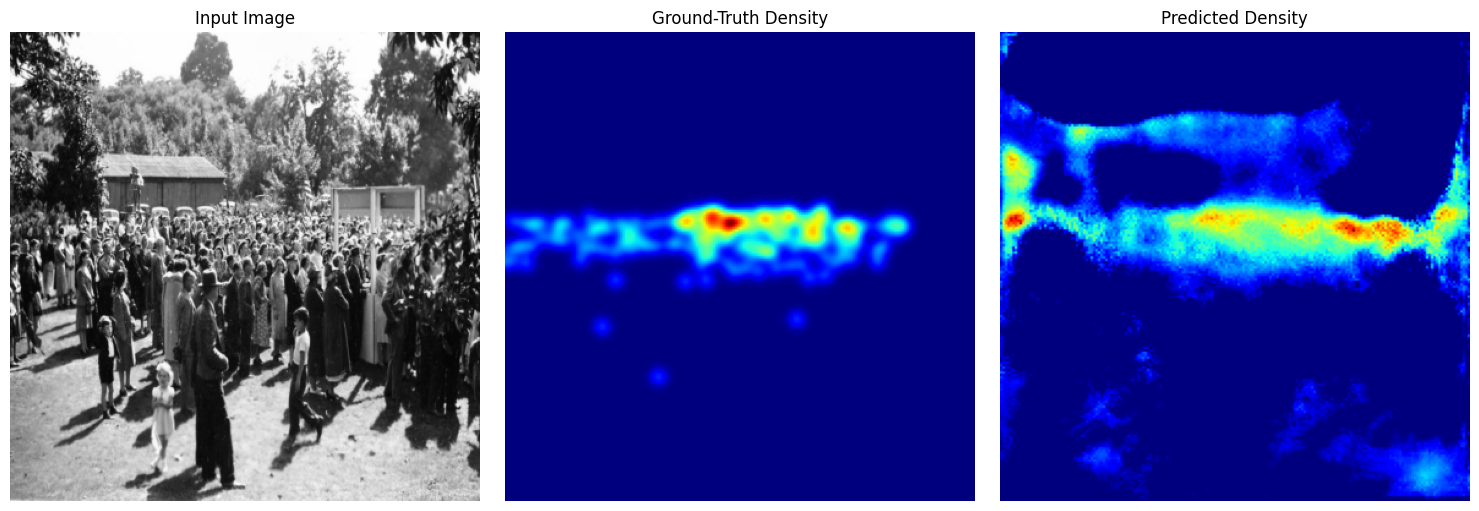

In [5]:
# 3) Load the finetuned model for inference
from models.resnet50_backbone import ResNet50Backbone

model = ResNet50Backbone(pretrained=True)
model.load_state_dict(torch.load("../models/pth/part_A_resnet50.pth", map_location=device))
model.to(device).eval()

# 4) Fetch one sample from the test set
test_loader = data_module.test_dataloader()
imgs, gt_maps = next(iter(test_loader))   # imgs: [B,3,H,W], gt_maps: [B,1,H,W]
img, gt_map   = imgs[0], gt_maps[0]       # pick first sample

# 5) Run inference
with torch.no_grad():
    input_img = img.unsqueeze(0).to(device)       # [1,3,H,W]
    pred_map  = model(input_img)                  # [1,1,H,W]
    pred_map  = pred_map.squeeze(0).squeeze(0).cpu().numpy()  # [H,W]

# 6) Plot RGB, ground-truth density, and predicted density
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img.permute(1, 2, 0).cpu())
axes[0].set_title("Input Image")
axes[0].axis("off")

# Ground-truth density
axes[1].imshow(gt_map.squeeze(0).cpu().numpy(), cmap="jet")
axes[1].set_title("Ground-Truth Density")
axes[1].axis("off")

# Predicted density
axes[2].imshow(pred_map, cmap="jet")
axes[2].set_title("Predicted Density")
axes[2].axis("off")

plt.tight_layout()
plt.show()


### VGG19bn Density map

Using device: cuda
Using CUDA: Tesla T4


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[vgg19_bn] Epoch 1/10  Train MSE: 0.003377, MAE: 0.001776  Val   MSE: 0.001272, MAE: 0.001135


[vgg19_bn] Epoch 2/10  Train MSE: 0.001287, MAE: 0.001210  Val   MSE: 0.001383, MAE: 0.001209


[vgg19_bn] Epoch 3/10  Train MSE: 0.001355, MAE: 0.001219  Val   MSE: 0.001430, MAE: 0.001224


[vgg19_bn] Epoch 4/10  Train MSE: 0.000845, MAE: 0.001057  Val   MSE: 0.001164, MAE: 0.001058


[vgg19_bn] Epoch 5/10  Train MSE: 0.000684, MAE: 0.000987  Val   MSE: 0.001021, MAE: 0.000954


[vgg19_bn] Epoch 6/10  Train MSE: 0.000622, MAE: 0.000923  Val   MSE: 0.001180, MAE: 0.001048


[vgg19_bn] Epoch 7/10  Train MSE: 0.000476, MAE: 0.000828  Val   MSE: 0.000948, MAE: 0.000876


[vgg19_bn] Epoch 8/10  Train MSE: 0.000444, MAE: 0.000821  Val   MSE: 0.001171, MAE: 0.001004


[vgg19_bn] Epoch 9/10  Train MSE: 0.000384, MAE: 0.000779  Val   MSE: 0.000933, MAE: 0.000824


[vgg19_bn] Epoch 10/10  Train MSE: 0.000328, MAE: 0.000721  Val   MSE: 0.001054, MAE: 0.000891
Saved weights to ../models/pth/part_A_vgg19.pth


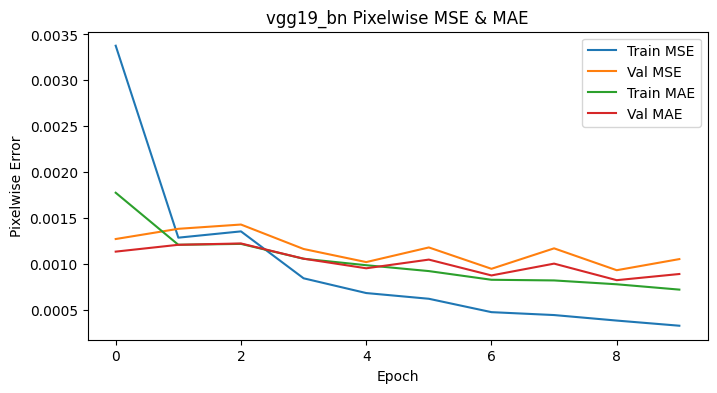

In [4]:
#Train

device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) Prepare the data
data_module = ShanghaiTechDataModule(
    data_folder="../data/ShanghaiTech",
    part="part_A",
    validation_split=0.1,
    sigma=5,
    return_count=False,
    batch_size=8,
    num_workers=4,
    density_map_size=(192, 192),
)

# 2) Train the model (15 epochs)
train_model(
    data_module,
    model_name="vgg19_bn",
    epochs=10,
    lr=1e-4,
    #batch_size=8,
    pretrained=True,
    save_path="../models/pth/part_A_vgg19.pth"
)


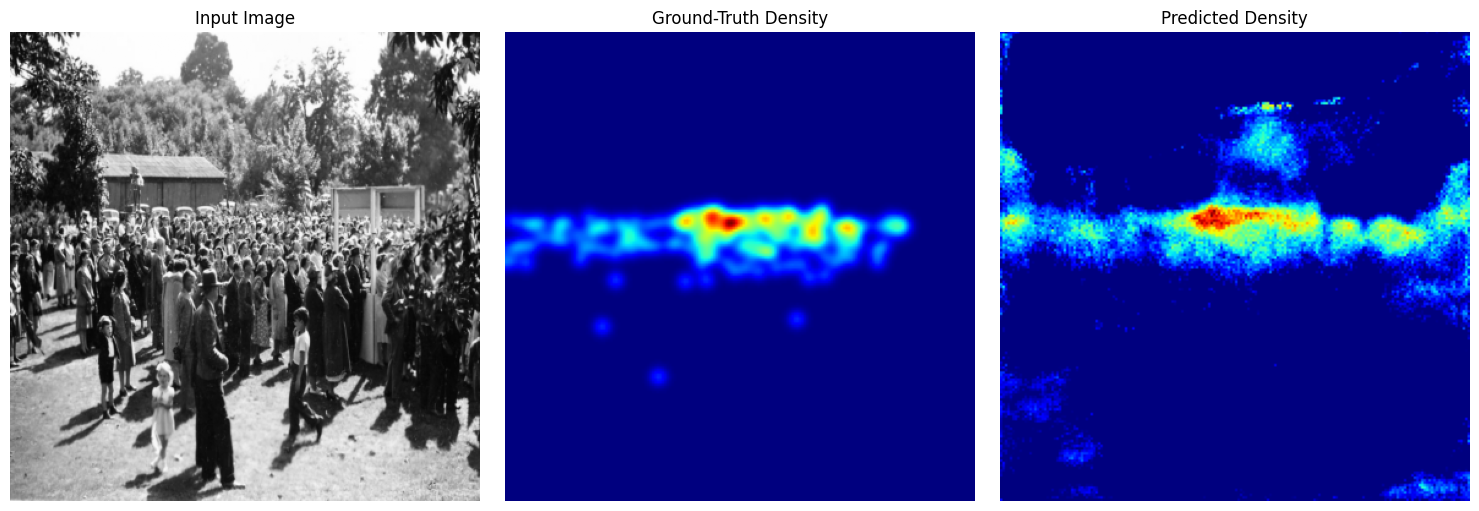

In [5]:
# 3) Load the finetuned model for inference
from models.vgg_backbone      import VGG19BNBackbone

model = VGG19BNBackbone(pretrained=True)
model.load_state_dict(torch.load("../models/pth/part_A_vgg19.pth", map_location=device))
model.to(device).eval()

# 4) Fetch one sample from the test set
test_loader = data_module.test_dataloader()
imgs, gt_maps = next(iter(test_loader))   # imgs: [B,3,H,W], gt_maps: [B,1,H,W]
img, gt_map   = imgs[0], gt_maps[0]       # pick first sample

# 5) Run inference
with torch.no_grad():
    input_img = img.unsqueeze(0).to(device)       # [1,3,H,W]
    pred_map  = model(input_img)                  # [1,1,H,W]
    pred_map  = pred_map.squeeze(0).squeeze(0).cpu().numpy()  # [H,W]

# 6) Plot RGB, ground-truth density, and predicted density
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img.permute(1, 2, 0).cpu())
axes[0].set_title("Input Image")
axes[0].axis("off")

# Ground-truth density
axes[1].imshow(gt_map.squeeze(0).cpu().numpy(), cmap="jet")
axes[1].set_title("Ground-Truth Density")
axes[1].axis("off")

# Predicted density
axes[2].imshow(pred_map, cmap="jet")
axes[2].set_title("Predicted Density")
axes[2].axis("off")

plt.tight_layout()
plt.show()
